In [1]:
# 读取数据
import numpy as np
import pandas as pd

rankdata_000 = pd.read_csv(
    r'D:\Study\Python\Workspace\rainbowSixSiege_analysis\datadump_s5_ranked_data\datadump_s5-000.csv')

In [2]:
# 初步筛选
data = rankdata_000.loc[:,
       ['matchid', 'roundnumber', 'gamemode', 'mapname', 'roundduration', 'skillrank', 'role', 'haswon']]
data = data.loc[data['role'] == 'Defender']

In [3]:
# 干员转换哑变量
opdata = pd.get_dummies(rankdata_000['operator'], drop_first=False, prefix='OP')
newdata = pd.merge(data, opdata, left_index=True, right_index=True)
new_matchid = newdata['matchid'].map(str) + "_" + newdata['roundnumber'].map(str) + "_" + newdata['role'].map(str)
newdata = newdata.drop(labels=['matchid', 'roundnumber', 'role'], axis=1)
newdata.insert(0, 'newmatchid', new_matchid, allow_duplicates=False)
newdata.head()

,newmatchid,gamemode,mapname,roundduration,skillrank,haswon,OP_BOPE-CAPITAO,OP_BOPE-CAVEIRA,OP_G.E.O.-JACKAL,OP_G.E.O.-MIRA,...,OP_SPETSNAZ-FUZE,OP_SPETSNAZ-GLAZ,OP_SPETSNAZ-KAPKAN,OP_SPETSNAZ-RESERVE,OP_SPETSNAZ-TACHANKA,OP_SWAT-ASH,OP_SWAT-CASTLE,OP_SWAT-PULSE,OP_SWAT-RESERVE,OP_SWAT-THERMITE
0,1522380841_1_Defender,HOSTAGE,CLUB_HOUSE,124,Gold,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1522380841_4_Defender,HOSTAGE,CLUB_HOUSE,217,Gold,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1522380841_3_Defender,HOSTAGE,CLUB_HOUSE,160,Gold,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1522380841_4_Defender,HOSTAGE,CLUB_HOUSE,217,Gold,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1522380841_6_Defender,HOSTAGE,CLUB_HOUSE,143,Gold,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# 数据数值化、离散化
newdata['gamemode'] = newdata['gamemode'].replace({'HOSTAGE': 1, 'BOMB': 2, 'SECURE_AREA': 3})
newdata['mapname'] = newdata['mapname'].replace(
    {'CLUB_HOUSE': 1, 'PLANE': 2, 'KANAL': 3, 'HEREFORD_BASE': 4, 'CONSULATE': 5,
     'YACHT': 6, 'OREGON': 7, 'BORDER': 8, 'SKYSCRAPER': 9, 'BANK': 10, 'COASTLINE': 11,
     'BARTLETT_U.': 12, 'HOUSE': 13, 'KAFE_DOSTOYEVSKY': 14, 'FAVELAS': 15, 'CHALET': 16})
newdata['skillrank'] = newdata['skillrank'].replace(
    {'Gold': 4, 'Unranked': 0, 'Platinum': 5, 'Silver': 3, 'Bronze': 1, 'Copper': 2, 'Diamond': 4})

In [5]:
# 个人数据转为对局数据
# 利用对局时间筛选无效数据
print(newdata.shape)
newdata_cp = newdata.copy()
newdata_cp = newdata_cp.loc[(newdata_cp['roundduration'] >= 90) & (newdata_cp['roundduration'] <= 210)]
res = newdata_cp.groupby(newdata_cp['newmatchid']).agg({max}).reset_index()
print(res.shape)

(2003883, 41)
(276252, 41)


In [6]:
# 转换为numpy训练矩阵
SCALE = res.shape[0]
label = np.array(res.loc[:SCALE - 1, :]['haswon'])
print(label.shape)
train_data = np.array(
    res.drop(labels=['newmatchid', 'haswon', 'gamemode', 'mapname', 'roundduration', 'skillrank'], axis=1).loc[:SCALE - 1, :])
print(train_data.shape)

(276252, 1)
(276252, 35)


C:\Users\Think\.conda\envs\pytorch_gpu\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
# # SVM with sklearn
# from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn import svm, metrics
#
# x_train, x_test, y_train, y_test = train_test_split(train_data, label, random_state=1, train_size=0.6)
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)
#
# clf = svm.SVC(kernel='linear', decision_function_shape='ovo', probability=True)
# clf.fit(x_train, y_train)
# clf.score(x_train, y_train)
# y_pre = clf.predict(x_test)
# svm_predprob = clf.predict_proba(x_test)[:, 1]
# print("[SVM]AUC Score (Train): %f" % metrics.roc_auc_score(y_test, svm_predprob, multi_class='ovo'))
#
# fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pre)
# plt.figure(figsize=(10, 6))
# plt.xlim(0, 1)
# plt.ylim(0.0, 1.1)
# plt.plot(fpr1, tpr1, color='red')
# plt.show()

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 0.714327  [    0/165751]
loss: 0.716793  [10240/165751]
loss: 0.708411  [20480/165751]
loss: 0.712518  [30720/165751]
loss: 0.702574  [40960/165751]
loss: 0.704632  [51200/165751]
loss: 0.707318  [61440/165751]
loss: 0.705574  [71680/165751]
loss: 0.700110  [81920/165751]
loss: 0.699802  [92160/165751]
loss: 0.696229  [102400/165751]
loss: 0.694798  [112640/165751]
loss: 0.692060  [122880/165751]
loss: 0.688538  [133120/165751]
loss: 0.686390  [143360/165751]
loss: 0.684431  [153600/165751]
loss: 0.682683  [163840/165751]
Test Error: 
 Accuracy: 59.6%, Avg loss: 0.683080 

Epoch 2
-------------------------------
loss: 0.685066  [    0/165751]
loss: 0.680147  [1

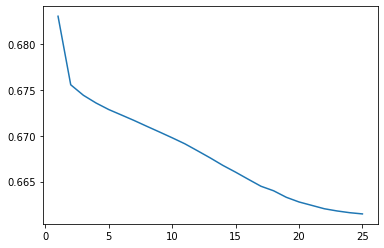

In [8]:
# MLP with PyTorch

import time
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt


# choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# prepare data
c = np.column_stack((train_data, label))  # 将y添加到x的最后一列
np.random.shuffle(c)
shuffled_data = c[:, :-1]  # 乱序后的x
shuffled_label = c[:, -1]  # 同等乱序后的y
SIZE = int(SCALE * 0.6)
train_x = shuffled_data[:SIZE]
test_x = shuffled_data[SIZE:]
y = []
for n in range(label.shape[0]):
    if label[n] == 0:
        y.append((1, 0))
    else:
        y.append((1, 0))
train_y = np.array(shuffled_label[:SIZE])
test_y = np.array(shuffled_label[SIZE:])


class CustomDataset(Dataset):
    def __init__(self, train):
        if train:
            self.data = torch.from_numpy(train_x.astype('float32')).to(torch.device(device))
            self.labels = torch.from_numpy(train_y).to(torch.device(device))
        else:
            self.data = torch.from_numpy(test_x.astype('float32')).to(torch.device(device))
            self.labels = torch.from_numpy(test_y).to(torch.device(device))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        d = self.data[idx]
        l = self.labels[idx]
        return d, l


learning_rate = 1e-4
batch_size = 1024
epochs = 25
input_dim = train_data.shape[1]
output_dim = label.shape[1]

train_dataset = CustomDataset(train=True)
test_dataset = CustomDataset(train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim + 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


model = NeuralNetwork().to(torch.device(device))
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test.append(test_loss)
print("Done! Running time: " + str(time.time() - start_time))
plt.plot(np.array(list(range(1, epochs + 1))), np.array(test))
plt.show()